In this notebook, my goal is to explore the SHAP (SHapley Additive exPlanations) values of a CatBoost classifier model. This notebook does not contain my EDA or any model improvements. 

SHAP values orginate from game theory give a unified approach to feature importanceSHAP values help in distributing the contribution of a prediction among its features. For example, if a model predicts that a loan application will be denied, SHAP values help in understanding how much each feature (e.g., income, credit score, etc.) contributed to that denial. This way, it provides a fair way to understand the impact of each feature on a specific prediction. 

There are two key ways to assess contributions using SHAP values:

- Local Interpretability: This involves examining each instance (or row) in the dataset to explain the difference between the model's prediction for that instance and the average prediction for all instances. This is crucial for understanding the model's prediction for a single instance, in this case, a person with a loan.

- Global Interpretability: By aggregating the SHAP values for all instances, one can obtain a global measure of feature importance, which is essential for understanding the model's overall behavior across the entire dataset.

While traditional feature importances offer global measures that indicate the overall importance of a feature in predicting the target variable across the entire dataset, they do not provide that local interpretability. SHAP values, on the other hand, offer a more comprehensive and fair way to interpret both local and global feature importance.

The specific benefits of local interpretability for this business use case are plenty:

- Regulatory Compliance: Financial institutions frequently face regulatory mandates to elucidate their decisions, particularly regarding loan approvals or denials. The ability to interpret the model's prediction for an individual is instrumental in providing the requisite explanations.

- Ensuring Fairness: It is imperative to ascertain that the model does not discriminate unjustly against any group of applicants. Analyzing the contributions of each feature for individual predictions enables the identification of any specific feature that may be exerting an undue influence on the model's decisions.

- Building Trust: Understanding the rationale behind individual predictions fosters trust in the model among all stakeholders, including the decision-makers within the financial institution, the applicants, and the regulators.

- Effective Risk Management: Discerning the reasons behind a prediction helps to the identify key risk factors for an applicant, and enables the design of appropriate risk mitigation strategies.

- Personalized Communication: In the event of a loan application denial, the financial institution can offer personalized feedback to the applicant, elucidating the key factors that influenced the decision. This empowers the applicant with the knowledge needed to enhance their chances of securing a loan in the future.

The benefits that SHAP provide here are clear. 

### Import Dependencies and Data

In [92]:
import pandas as pd
import numpy as np  
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score
import catboost as cb
from catboost import CatBoostClassifier, Pool, cv
import shap 
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN
import optuna

pd.set_option('display.max_columns', 500)

In [93]:
df = pd.read_csv('Anonymize_Loan_Default_data.csv', encoding='latin-1')

### Clean and Process the Data

In [94]:
# Remove unwanted columns
df = df.drop(columns=['Unnamed: 0', 'id','zip_code'])

In [95]:
# These are the columns that are not being included in the model as they will not be available for new loan applications
not_included = [
    'loan_status','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt', 
    'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'funded_amnt', 'funded_amnt_inv',
]

df = df.drop(columns=not_included)

### Feature Engineering Ideas

- Ratio of the loan amount to annual income.
- Ratio of the monthly installment to monthly income.
- Log transformation of annual income to reduce the impact of outliers.
- Categorize annual income into different bins (e.g., low, medium, high income).
- Number of years between the earliest credit line and the last credit inquiry.
- Number of credit inquiries in the last 6 months, 1 year, 2 years, etc.
- Ratio of the loan amount to the annual income.
- Difference between the funded amount and the loan amount.

In [96]:
# Ratio of the loan amount to annual income
df['loan_amnt_to_annual_inc'] = df['loan_amnt'] / df['annual_inc']

In [97]:
# Ratio of the monthly installment to monthly income
df['installment_to_monthly_inc'] = df['installment'] / (df['annual_inc'] / 12)

In [98]:
# Log transformation of annual income
df['log_annual_inc'] = np.log(df['annual_inc'] + 1)

In [99]:
# Categorize annual income into different bins
bins = [0, 30000, 60000, np.inf]
labels = ['low', 'medium', 'high']
df['income_category'] = pd.cut(df['annual_inc'], bins=bins, labels=labels)

# If the income_category is null, then set it to low
df['income_category'] = df['income_category'].fillna('low')


In [100]:
# Map the months to numbers
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
          'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df['earliest_cr_month'] = df['earliest_cr_line'].str[:3].map(months)

# Extract the year from the 'earliest_cr_line' column
df['earliest_cr_year'] = df['earliest_cr_line'].str[-2:].astype(int)

# Get the current year and month
current_year = datetime.now().year % 100  # Get the last two digits of the current year
current_month = datetime.now().month

# Assume that any year less than or equal to the current year and any month less than or equal to the current month is from the 21st century,
# and any other year or month is from the 20th century
df['earliest_cr_year'] = np.where((df['earliest_cr_year'] <= current_year) & (df['earliest_cr_month'] <= current_month), 
                                  df['earliest_cr_year'] + 2000, 
                                  df['earliest_cr_year'] + 1900)

# Calculate the number of years between the earliest credit line and the current year
df['years_since_earliest_cr_line'] = datetime.now().year - df['earliest_cr_year']

# Drop the original 'earliest_cr_line' column
df = df.drop('earliest_cr_line', axis=1)

In [101]:
# Get the current date
current_date = datetime.now()

# Fill missing values in the 'last_credit_pull_d' column with the current date
df['last_credit_pull_d'] = df['last_credit_pull_d'].fillna(current_date.strftime('%b-%y'))

# Extract the month and year from the 'last_credit_pull_d' column
df['last_credit_pull_month'] = df['last_credit_pull_d'].str[:3].map(months)
df['last_credit_pull_year'] = df['last_credit_pull_d'].str[-2:].astype(int)

# Assume that any year less than or equal to the current year and any month less than or equal to the current month is from the 21st century,
# and any other year or month is from the 20th century
df['last_credit_pull_year'] = np.where((df['last_credit_pull_year'] <= current_year) & (df['last_credit_pull_month'] <= current_month), 
                                       df['last_credit_pull_year'] + 2000, 
                                       df['last_credit_pull_year'] + 1900)

df['years_since_last_credit_pull'] = datetime.now().year - df['last_credit_pull_year']

# Drop the original 'last_credit_pull_d' column
df = df.drop('last_credit_pull_d', axis=1)

In [102]:
df.drop(columns=['annual_inc'], inplace=True)

In [103]:
# Define columns by type. We will process each type of column differently
numeric_cols = [
        'loan_amnt','int_rate','installment',
        'dti','delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
        'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc','loan_amnt_to_annual_inc',
        'installment_to_monthly_inc','log_annual_inc','years_since_earliest_cr_line',
        'earliest_cr_month', 'earliest_cr_year','years_since_earliest_cr_line', 'last_credit_pull_month', 
        'last_credit_pull_year','years_since_last_credit_pull'
        ]

categorical_cols = [
        'term', 'emp_length', 'home_ownership', 'verification_status','purpose','addr_state','income_category',
        ]


In [104]:
# Function to handle missing values based on column type
def handle_missing_values(df):
    # Remove non-numeric characters and convert 'revol_util' to numeric
    df['revol_util'] = df['revol_util'].str.replace('[^0-9.]', '', regex=True)
    df['revol_util'] = pd.to_numeric(df['revol_util'], errors='coerce') / 100.0
    
    # Impute numeric columns with mean
    for col in numeric_cols:
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)
    
    # Handle categorical columns with unknown
    for col in categorical_cols:
        df[col].fillna("Unknown", inplace=True)
      
    # Special handling for specific columns
    df['mths_since_last_delinq'].fillna(0, inplace=True)
    
    return df

In [105]:
# Apply the functions
df2 = handle_missing_values(df)

In [106]:
# # Get indices of categorical columns to be used by CatBoost
# categorical_cols_ind = [df2.columns.get_loc(col) for col in categorical_cols]

### Split the data for training/testing

In [107]:
# Train/test split
X = df2.drop(columns=['repay_fail','member_id'])
y = df2['repay_fail']

# members = df2['member_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

### CatBoost Classifer 

I opted to use a CatBoost model to take advantage of its built in categorical feature handling. The metric I am focusing on is recall as it would be most important to the business to not miss any instances of a potential default on a loan. 

In [108]:
def objective(trial):
    
    # Define class weights
    class_weight_option = trial.suggest_categorical('class_weight_option', [None, 'balanced', 'custom'])
    if class_weight_option == 'balanced':
        class_weights = list(len(y_train) / (2 * np.bincount(y_train)))
    elif class_weight_option == 'custom':
        class_weights = [trial.suggest_float('class_weight_0', 0.1, 10), trial.suggest_float('class_weight_1', 0.1, 10)]
    else:
        class_weights = None

    param = {
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'verbose': False,
        'random_seed': 123,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'depth': trial.suggest_int('depth', 1, 16), 
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'max_bin': trial.suggest_int('max_bin', 1, 254),  
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 100.00),
        'random_strength': trial.suggest_int('random_strength', 1, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 1, 50),
        'class_weights': class_weights,
        'cat_features': [X_train.columns.get_loc(col) for col in categorical_cols],

    }

    model = CatBoostClassifier(**param)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, plot=False)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred)
    return score

sampler = optuna.samplers.TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters
best_params = study.best_params
best_params.pop('class_weight_option', None)
print(best_params)
# Print the best score
print(study.best_value)

In [109]:
# # Print the best parameters
# best_params = study.best_params
# best_params.pop('class_weight_option', None)
# print(best_params)
# # Print the best score
# print(study.best_value)

In [110]:
best_params = {
    'class_weights': [1.8507668648240136, 8.276066456260143],
    'learning_rate': 0.262693267365983, 
    'l2_leaf_reg': 7,
    'depth': 7,
    'grow_policy': 'Lossguide',
    'min_data_in_leaf': 21,
    'max_bin': 98,
    'bagging_temperature': 77.15319252719308,
    'random_strength': 97,
    'od_type': 'IncToDec',
    'od_wait': 42
}

In [111]:
# print confusion matrix for best model
model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, plot=False, 
          cat_features=[X_train.columns.get_loc(col) for col in categorical_cols])
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(f'The f1 score is: {f1_score(y_test, y_pred)}')
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The recall score is: {recall_score(y_test, y_pred)}')


0:	learn: 0.6818330	test: 0.6832477	best: 0.6832477 (0)	total: 19ms	remaining: 19s
1:	learn: 0.6769922	test: 0.6788417	best: 0.6788417 (1)	total: 38.5ms	remaining: 19.2s
2:	learn: 0.6732261	test: 0.6755605	best: 0.6755605 (2)	total: 57.3ms	remaining: 19.1s
3:	learn: 0.6651634	test: 0.6693065	best: 0.6693065 (3)	total: 79.3ms	remaining: 19.7s
4:	learn: 0.6599429	test: 0.6658686	best: 0.6658686 (4)	total: 97.5ms	remaining: 19.4s
5:	learn: 0.6526524	test: 0.6595760	best: 0.6595760 (5)	total: 116ms	remaining: 19.2s
6:	learn: 0.6509694	test: 0.6581228	best: 0.6581228 (6)	total: 132ms	remaining: 18.7s
7:	learn: 0.6466209	test: 0.6550494	best: 0.6550494 (7)	total: 152ms	remaining: 18.8s
8:	learn: 0.6455227	test: 0.6547963	best: 0.6547963 (8)	total: 172ms	remaining: 19s
9:	learn: 0.6437402	test: 0.6534164	best: 0.6534164 (9)	total: 194ms	remaining: 19.2s
10:	learn: 0.6426137	test: 0.6529624	best: 0.6529624 (10)	total: 215ms	remaining: 19.3s
11:	learn: 0.6409247	test: 0.6523532	best: 0.6523532 

## SHAP Values for the CatBoost Model
Below I will highlight what plots and features SHAP provides. 

In [112]:
# Create a TreeExplainer object - as CatBoost is a tree-based model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [113]:
# SHAP values - a value of 0 means the feature did not impact the model's prediction for that instance
# A negative value means that the value of that feature for that specific instance decreases the predicted 
# probability of the positive class. A positive value means that the value of that feature for that specific
# instance increases the predicted probability of the positive class.

shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns.values)
shap_values_df['repay_fail'] = y_test.values

# # Add the member ids back in
# shap_values_df['member_id'] = members
# # Move member_id to the first column
# cols = list(shap_values_df.columns.values)
# cols.pop(cols.index('member_id'))
# shap_values_df = shap_values_df[['member_id'] + cols]

shap_values_df.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,loan_amnt_to_annual_inc,installment_to_monthly_inc,log_annual_inc,income_category,earliest_cr_month,earliest_cr_year,years_since_earliest_cr_line,last_credit_pull_month,last_credit_pull_year,years_since_last_credit_pull,repay_fail
0,-0.074054,-0.342125,0.226774,-0.133405,-0.180190,-0.029172,-0.124053,0.060674,0.136072,0.014553,-0.002707,-0.173113,-0.011392,-0.027937,0.015853,0.291183,0.244987,-0.003928,0.139832,0.282926,-0.002271,-0.285052,0.259851,-0.008210,-0.090881,-0.005154,0.119156,0.413004,0
1,-0.186007,1.084504,0.106437,-0.322213,0.139122,-0.011587,-0.141981,-0.024367,0.029978,0.048897,-0.004428,0.054628,-0.073033,-0.081046,0.020944,0.236530,0.227849,-0.020036,0.190056,-0.330114,0.084954,-0.162715,-0.004197,0.083191,-0.076074,-0.234130,-0.232595,-0.346911,1
2,0.122589,-0.332218,-0.031101,-0.183212,-0.007358,-0.012031,-0.092314,0.103387,0.184409,0.006381,-0.002476,0.055519,-0.049742,-0.074203,0.016951,-0.415466,0.201058,-0.008262,0.080837,-0.177623,-0.074654,-0.134571,0.070248,0.026092,0.008605,0.116447,-0.314876,0.147562,0
3,0.045555,-0.356052,0.115861,0.096577,0.144278,-0.040028,-0.065918,0.081965,-0.058453,0.100213,-0.002354,0.170460,-0.086924,0.097108,0.012248,-0.375971,-0.057793,0.089666,-0.346410,0.102925,0.340414,0.049416,-0.318005,0.140490,0.004385,0.067884,-0.237477,-0.117228,0
4,0.093987,-0.319845,0.119357,0.248829,0.026469,-0.021653,0.335519,0.195240,0.134710,0.036800,-0.002851,0.476360,0.005814,0.027649,0.011541,0.384819,-0.171208,-0.091351,-0.120430,-0.083401,-0.236460,-0.253397,0.465416,-0.023002,0.034002,-0.052614,0.066950,0.142296,0


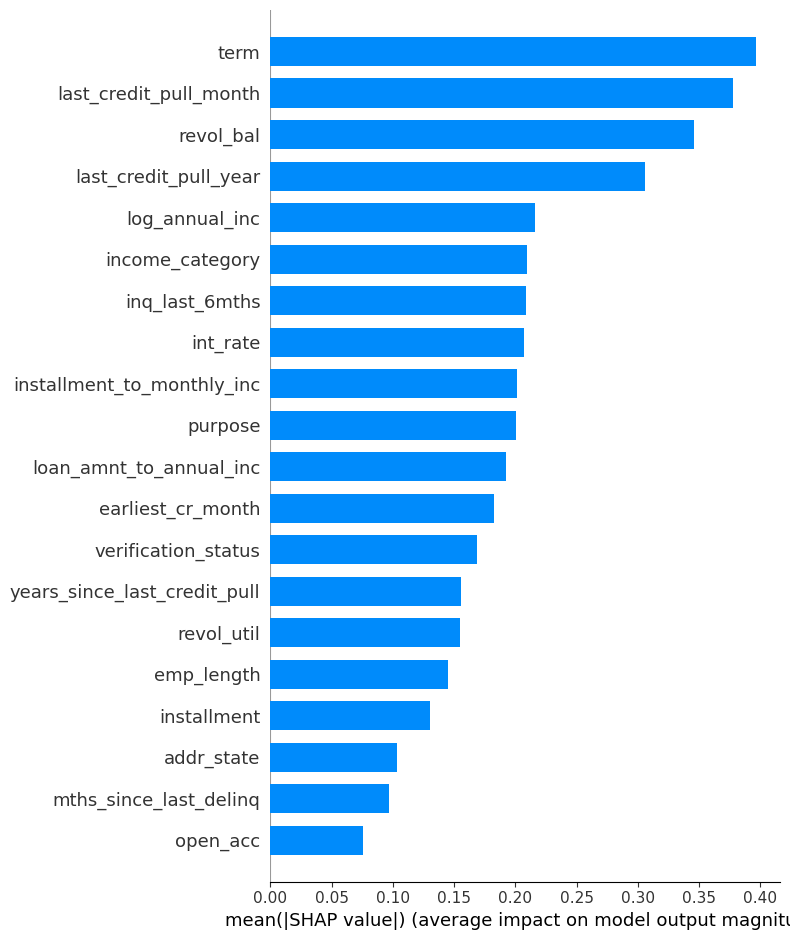

In [114]:
# Summary plot - this plot provides a global overview of the feature importance across the entire dataset. 
# It shows the SHAP values of each feature for all the instances in the dataset, giving an 
# idea of the distribution of the SHAP values and the overall impact of each feature.

shap.summary_plot(shap_values, X_test, plot_type="bar")

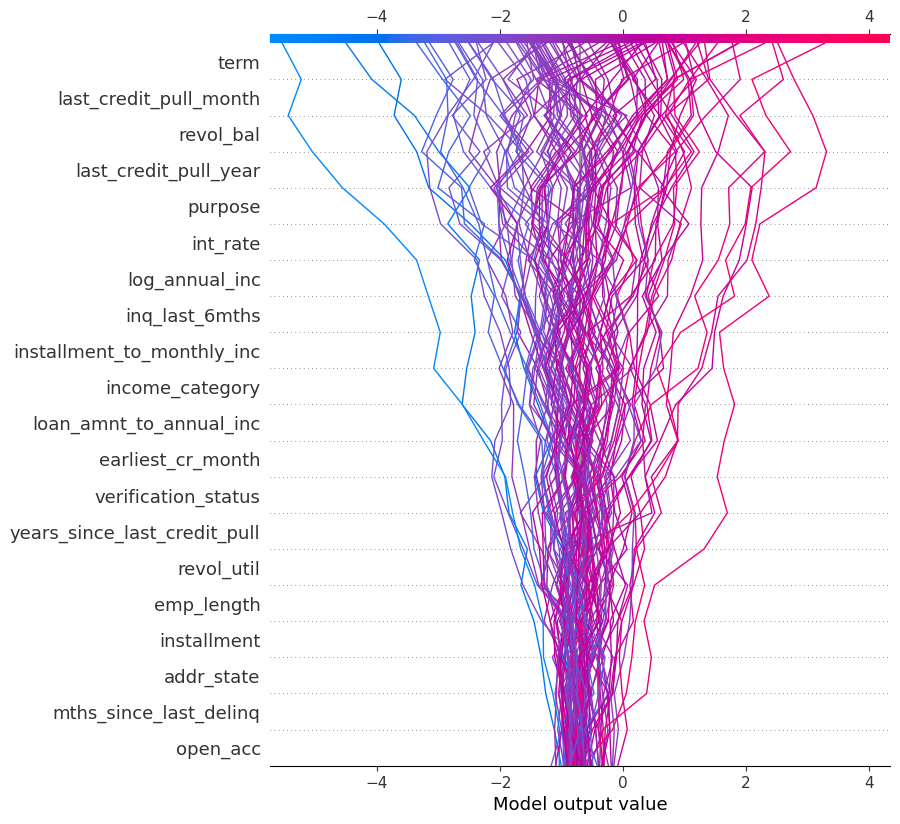

In [115]:
# Decision plot - this plot provides a global explanation of the model by plotting the
# SHAP values for each instance in the dataset. The color represents the feature value
# (red high, blue low). The x-axis shows the SHAP value of the feature for that instance
# and the y-axis shows the feature value. The plot is essentially a scatter plot of SHAP 
# values colored by the feature value. The plot can be interpreted as how the model works 
# for different feature values. Here I am only using a subset of the data to speed up the plot

shap.decision_plot(explainer.expected_value, shap_values[:100,:], X_test.iloc[:100,:])


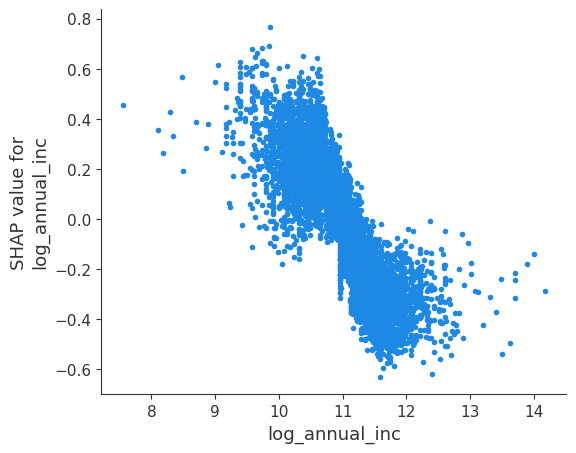

In [116]:
# Dependence plot - this plot shows the effect of a single feature across the whole dataset.
# The x-axis shows the feature value and the y-axis shows the SHAP value of that feature.
# The plot is essentially a scatter plot of SHAP values colored by the feature value.
# Vertical dispersion at a single feature value represents interaction effects with other
# features. with interaction index set to None, the plot shows the original SHAP value for 
# a feature

shap.dependence_plot('log_annual_inc', shap_values, X_test, interaction_index=None)


In [117]:
# Force plot - this plot provides a local explanation for a single prediction. It shows the
# features that pushed the model towards a certain prediction for a specific instance.
# The red color indicates that the feature value is high and pushed the model towards a
# positive prediction, while the blue color indicates that the feature value is low and
# pushed the model towards a negative prediction.

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[150,:])

In [118]:
# The tabular view of the instance captured in the force plot above and waterfall below
X_test.iloc[150,:]

loan_amnt                                  20000.0
term                                     36 months
int_rate                                     14.72
installment                                 690.57
emp_length                                 3 years
home_ownership                                RENT
verification_status                       Verified
purpose                         debt_consolidation
addr_state                                      NY
dti                                           6.82
delinq_2yrs                                    0.0
inq_last_6mths                                 1.0
mths_since_last_delinq                        73.0
open_acc                                       8.0
pub_rec                                        0.0
revol_bal                                  19964.0
revol_util                                   0.889
total_acc                                     19.0
loan_amnt_to_annual_inc                   0.114286
installment_to_monthly_inc     

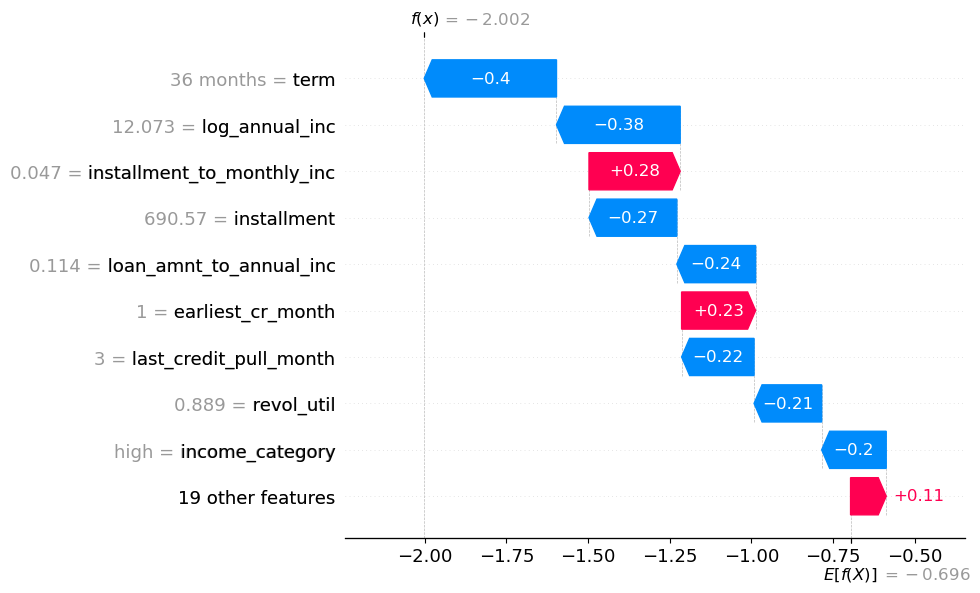

In [119]:
# Waterfall plot - this plot provides a local explanation for a single prediction. It shows
# the features that pushed the model towards a certain prediction for a specific instance.
# The red color indicates that the feature value is high and pushed the model towards a
# positive prediction, while the blue color indicates that the feature value is low and
# pushed the model towards a negative prediction.

row = 150 # index of the row to explain
shap_values_row = shap_values[row]
expl = shap.Explanation(values=shap_values_row,
                        base_values=explainer.expected_value,
                        data=X_test.iloc[row,:],
                        feature_names=X_test.columns)

shap.waterfall_plot(expl)


### Summary
Its clear from the visualizations that loan status is a the strongest predictor of failure to repay a loan. This is supported by the exploratory data analysis which shows each loan status category as completely filled by one class or the other. 

To see a completed version of my work including an exciting logit regression model exploring the significance of loan status in this data set, check out my GitHub repo: https://github.com/earlyann/anonymized_loan_repayment_predictions